In [220]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

from main.laplace_batch import stochastic_greedy_maxlogdet

In [230]:
class Select:

    def __init__(self, K, pool_indices, batch_size) -> None:
        self.B = torch.zeros(len(pool_indices), batch_size)
        self.c = K.diag() + 1
        self.K = K
        self.batch_size = batch_size
        self.n_added = 0

    def add(self, x, pool_indices):
        B = self.B[:, :self.n_added]
        mat_col = self.K[pool_indices, x] + torch.eye(self.K.shape[0])[pool_indices, x]
        BtB = B.matmul(B[x,:])

        v = (1/(self.c[x]).sqrt()) * (mat_col - BtB)  # CHECK WHY 1 / SQRT

        self.B = torch.cat((self.B, v.view(-1, 1)), dim=1)

        self.c -= v ** 2

    def next(self, pool_indices):
        choice = torch.argmax(self.c[pool_indices])
        return choice
    
    def select(self, pool_indices):
        batch_indices = torch.zeros(self.batch_size)

        for i in range(self.batch_size):
            x = self.next(pool_indices)
            self.add(x, pool_indices)
            batch_indices[i] = x

            self.n_added += 1
            self.c[x] = -np.Inf

        return batch_indices

tensor(5)


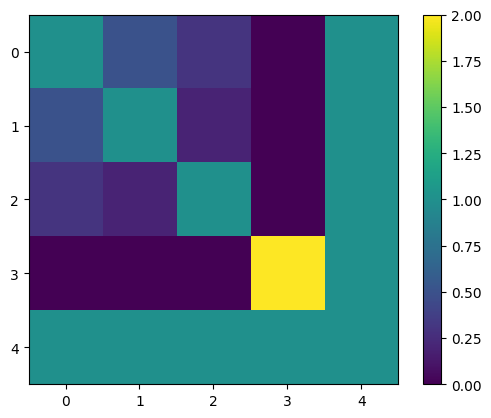

In [209]:
kernel = torch.tensor([[1, 0.5, 0.3, 0, 1],
                       [0.5, 1, 0.2, 0, 1],
                       [0.3, 0.2, 1, 0, 1],
                       [0, 0, 0, 2, 1],
                       [1, 1, 1, 1, 1]])

#kernel = torch.cov(torch.randn(5, 100))

plt.imshow(kernel)
plt.colorbar()
print(torch.linalg.matrix_rank(kernel))

running 100
running 500
running 1000
running 2000
running 5000
running 10000


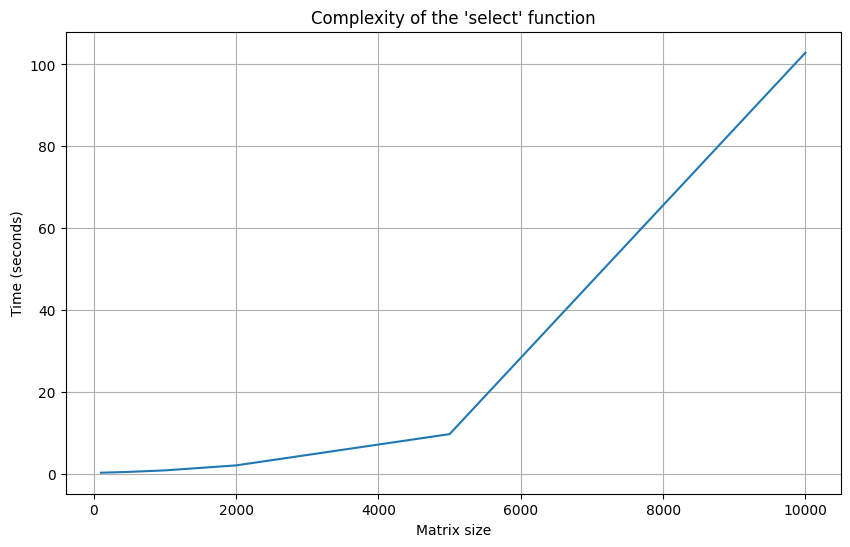

In [232]:
# Test the speed of the select function for increasing matrix sizes
sizes = [100, 500, 1000, 2000, 5000, 10000]
repeat = 20

times = []

for size in sizes:
    print('running {}'.format(size))
    K = torch.randn(size, size)
    pool_indices = torch.arange(size)
    batch_size = 100

    select_obj = Select(K, pool_indices, batch_size)

    start_time = time.time()
    for _ in range(repeat):
        select_obj.select(pool_indices)
    end_time = time.time()

    times.append(end_time - start_time)

# Plot the complexity
plt.figure(figsize=(10, 6))
plt.plot(sizes, times)
plt.xlabel("Matrix size")
plt.ylabel("Time (seconds)")
plt.title("Complexity of the 'select' function")
plt.grid(True)
plt.show()

running 100
running 500
running 1000
running 2000
running 5000
running 10000


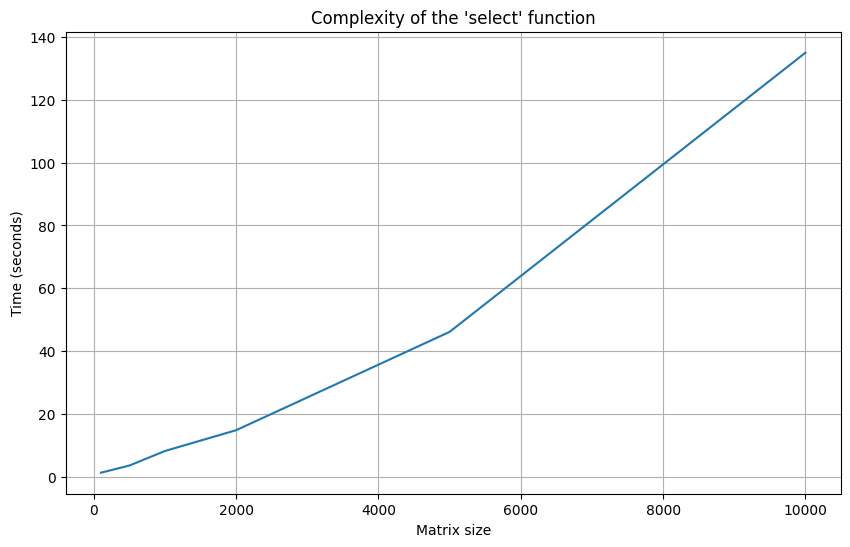

In [234]:
# Test the speed of the select function for increasing matrix sizes
sizes = [100, 500, 1000, 2000, 5000, 10000]
repeat = 20

times = []

for size in sizes:
    print('running {}'.format(size))
    K = torch.randn(size, size)
    pool_indices = torch.arange(size)
    batch_size = 100

    select_obj = Select(K, pool_indices, batch_size)

    start_time = time.time()
    for _ in range(repeat):
        stochastic_greedy_maxlogdet(matrix=K, k=batch_size)
    end_time = time.time()

    times.append(end_time - start_time)

# Plot the complexity
plt.figure(figsize=(10, 6))
plt.plot(sizes, times)
plt.xlabel("Matrix size")
plt.ylabel("Time (seconds)")
plt.title("Complexity of the 'select' function")
plt.grid(True)
plt.show()

In [ ]:
import torch
import time
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to run the select function test for a given matrix size
def run_select_test(size, repeat):
    print(f'Running {size}')
    K = torch.randn(size, size)
    pool_indices = torch.arange(size)
    batch_size = 100
    
    select_obj = Select(K, pool_indices, batch_size)

    start_time = time.time()
    for _ in range(repeat):
        select_obj.select(pool_indices=pool_indices)
    end_time = time.time()
    
    return end_time - start_time

# List of matrix sizes and the number of repetitions
sizes = [10^3, 10^4, 10^5, 10^6]
repeat = 10

# Use ThreadPoolExecutor to run tests in parallel
times = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(run_select_test, size, repeat): size for size in sizes}

    for future in as_completed(futures):
        size = futures[future]
        try:
            time_taken = future.result()
            times.append(time_taken)
        except Exception as e:
            print(f"An error occurred with size {size}: {e}")

# Plot the complexity
plt.figure(figsize=(10, 6))
plt.plot(sizes, times)
plt.xlabel("Matrix size")
plt.ylabel("Time (seconds)")
plt.title("Complexity of the 'select' function")
plt.grid(True)
plt.show()
